# Shlukování

Vlastín implementace KMeans a porovnání s KMeans ve `sklearn` a další pozorování na datech pomocí shlukování
    
## Data

Zdrojem dat je soubor `CC GENERAL.csv` (originál zde: https://www.kaggle.com/datasets/arjunbhasin2013/ccdata).

In [2]:
import pandas as pd
import numpy as np

from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import fcluster

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [3]:
df = pd.read_csv("CC GENERAL.csv")

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           8950 non-null   object 
 1   BALANCE                           8950 non-null   float64
 2   BALANCE_FREQUENCY                 8950 non-null   float64
 3   PURCHASES                         8950 non-null   float64
 4   ONEOFF_PURCHASES                  8950 non-null   float64
 5   INSTALLMENTS_PURCHASES            8950 non-null   float64
 6   CASH_ADVANCE                      8950 non-null   float64
 7   PURCHASES_FREQUENCY               8950 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 11  CASH_ADVANCE_TRX                  8950 non-null   int64  
 12  PURCHA

Podle základního výstupu můžeme vidět, že v datech je malé množství chybějících hodnot. Pouze ve sloupcích CREDIT_LIMIT je jedna chybějící hodnota  a MINIMUM_PAYMENTS, ve kterém chybí zhruba 300 záznamů. Pokud nahlédneme přímo do dat, je možné si všimnout, že hodnota ve sloupci MINIMUM_PAYMENTS není vyplněna, většinou když hodnota ve sloupci PAYMENTS je nulová, tedy že uživatel neprovedl žádnou platbu a tedy nemůže existovat ani minimální platba. Ovšem tohle neplatí absolutně, a tak doplním chybějící hodnoty hodnotami ze sloupce PAYMENTS. Tam kde uživatel žádnou platbu neprovedl, bude nula,  jinde bude hodnota všech plateb.

In [5]:
df["MINIMUM_PAYMENTS"].fillna(df["PAYMENTS"], inplace=True)

Jednu chybějící hodnotu ve sloupci CREDIT_LIMIT doplním mediánem sloupce.

In [6]:
df["CREDIT_LIMIT"].fillna(df["CREDIT_LIMIT"].median(), inplace=True)

Dále odstraním sloupec CUST_ID, protože obsahuje unikátní hosnoty na základě, kterých se shlukovací algoritmus nebude rozhodovat a zároveň tento příznak není numerický, takže bych ho buď musela převést, nebo ho odstraním. Já osobně ho radši odstraním

In [7]:
df.drop(["CUST_ID"], axis=1, inplace=True)

Nakonec ještě zkontroluji, zda nikde nechybí žádná hodnota. 

In [8]:
df.isnull().sum()

BALANCE                             0
BALANCE_FREQUENCY                   0
PURCHASES                           0
ONEOFF_PURCHASES                    0
INSTALLMENTS_PURCHASES              0
CASH_ADVANCE                        0
PURCHASES_FREQUENCY                 0
ONEOFF_PURCHASES_FREQUENCY          0
PURCHASES_INSTALLMENTS_FREQUENCY    0
CASH_ADVANCE_FREQUENCY              0
CASH_ADVANCE_TRX                    0
PURCHASES_TRX                       0
CREDIT_LIMIT                        0
PAYMENTS                            0
MINIMUM_PAYMENTS                    0
PRC_FULL_PAYMENT                    0
TENURE                              0
dtype: int64

In [9]:
# create a matrix of values
X = df.values

## Vlastní implementace algoritmu kMeans

In [19]:
def k_means(X, k, max_iter):
    not_finished = 1
    cluster = np.zeros(X.shape[0])
    best_score = float('inf')
    # try as many as max_iter is
    for i in range(max_iter):
        # initiliaze first centroids, as random points
        centroids = df.sample(n=k, random_state=42).values
        while not_finished:
            for idx, row in enumerate(X):
                distance = float('inf')
                # distance of the point from all centroids
                for index, centroid in enumerate(centroids):
                        # calculate the Eukledian distance metrics - distance between point and cluster
                        eklid_d = np.linalg.norm(centroid - row)
                        if distance > eklid_d:
                            distance = eklid_d
                            cluster[idx] = index
            new_centroids = pd.DataFrame(X).groupby(by=cluster).mean().values
            # if centroids are same stop the loop
            if np.array_equal(centroids, new_centroids):
                not_finished = 0
            else:
                centroids = new_centroids
        # using silhouette_score compare current clusters to the current best ones
        tmp_score = silhouette_score(X,cluster)
        if tmp_score < best_score:
            # store the best of every needed variable
            best_score = tmp_score
            best_clusters = cluster
            best_centroids = centroids
    return best_centroids, best_clusters, best_score


Implementace je pomalá, protože využívá funkci silhouette_score pro zjištění nejlepšího rozdělení. Bohužel jsem nepřišla s lepším řešením. Ale pokud svolím parametr max_iter = 5, doba trvání je zhruba 25s. Což je sice příšerné, ale dá na to počkat.  Nyní ho zkusím otestovat podle grafu, zda budou vypadat podobně. 

In [20]:
centroids, clusters, score = k_means(X, 2, 5)
print(score)

0.5117538817887547


Skóre pod 0.5 není ideální, ale tím, že iteruji velmi málo, nelze očekávat dobrý výsledek. Pro představu si vykreslím graf dvou proměných, např. PAYMENTS a MINIMUM_PAYMENTS. 

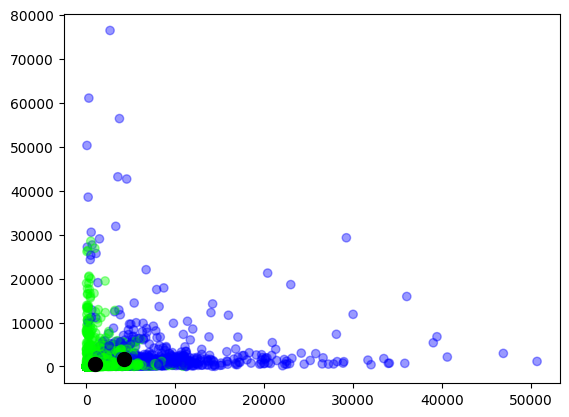

In [21]:
plt.scatter(X[:,13], X[:,14], c=clusters, cmap='brg', alpha=0.4) 
plt.scatter(centroids[:,13], centroids[:,14], c = 'black', s=100)
plt.show()

## Shlukování pomocí funkce kMeans ve Sklearn

In [23]:
kmeans = KMeans(n_clusters = 2, random_state=42).fit(X)

Vykreslím si graf stejných proměnných jako při vlastní implmentaci. Tedy:  PAYMENTS a MINIMUM_PAYMENTS. 

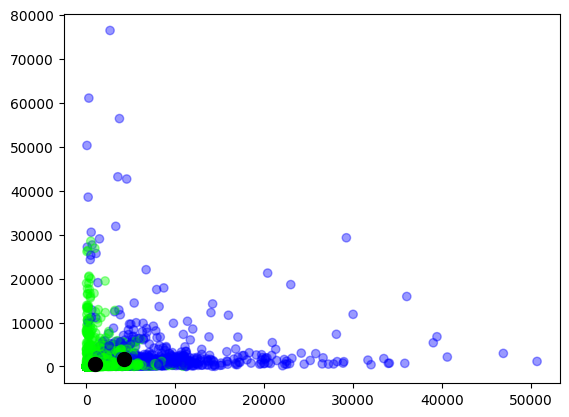

In [24]:
plt.scatter(X[:,13], X[:,14], c=kmeans.labels_, cmap='brg', alpha=0.4) 
plt.scatter(kmeans.cluster_centers_[:,13], kmeans.cluster_centers_[:,14], c = 'black', s=100)
plt.show()

Je vidět, že grafy jsou velmi podobné. Centroidy vypadají na podobných místech a i barvy shluký sedí, což by vůbec nemusely. Nicméně pro další úkoly použiji knihovní funkci kMeans, protože výsledků té mojí implementované bychom se asi nedočkali. 

In [40]:
print("Percentage of wrongly assigned points:",np.count_nonzero(kmeans.labels_-clusters)/len(clusters))
print("Number of wrongly assingned points:",np.count_nonzero(kmeans.labels_-clusters))

Percentage of wrongly assigned points: 0.000111731843575419
Number of wrongly assingned points: 1


Dokonce pokud porovnáme výsledné pole z knihovní i ručně implementované funkce kMeans, získáme relativně přívětivý výsledek. Můžu tedy prohlásit, že moje implementace funguje. Sice pomalu, ale funguje. 

## Odhadnutí vhodného počtu shluků

Pro odhadnutí nejlepšího počtu shluku, neboli hodnoty n_clusters, použiji metodu lokte. Tam kde bude v grafu "zlom" je nelepší počet shluků.

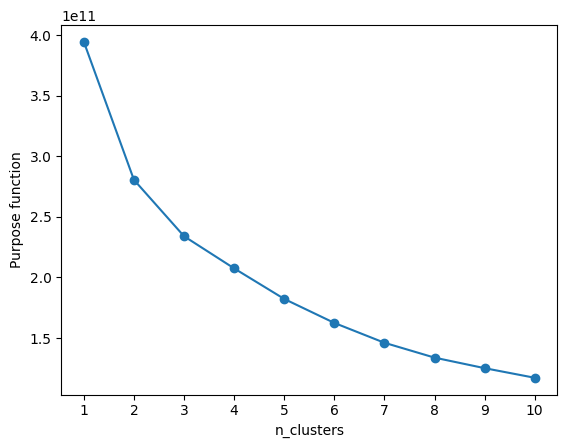

In [ ]:
array = np.arange(10)
array2 = np.arange(1,11)
for k in range(array.shape[0]):
    kmeans = KMeans(n_clusters=k+1, init = 'k-means++')
    kmeans.fit(X)
    array[k] = kmeans.inertia_

plt.xlabel('n_clusters')
plt.ylabel('Purpose function')
plt.xticks(array2)
plt.plot(array2, array, 'o-')
plt.show()

Z grafu "zlom" není tak jasně viditelný. Ale zhruba pro 2 nebo 3 shluky to vypadá, že výsledek bude optimální.

## Evaluace pomocí silhouette_score

In [ ]:
kmeans = KMeans(n_clusters = 2, init = 'k-means++')
y = kmeans.fit_predict(X)

In [ ]:
score = silhouette_score(X,y)
print(score)

0.511683481318523


Hodnota silhouette_score není tak špatná, je dokonce lepší než moje osobní implementace. Výsledek nad 0.5 je přijatelný. 

## Hierarchické shlukování a dendrogram

Pro hierarchické shlukování použiji funkci linkage z knihovny scipy.cluster.hierarchy. Jako metodu použiji "complete linkage" a  euklidovskou metriku.

In [52]:
Z = linkage(X, method="complete", metric="euclidean")

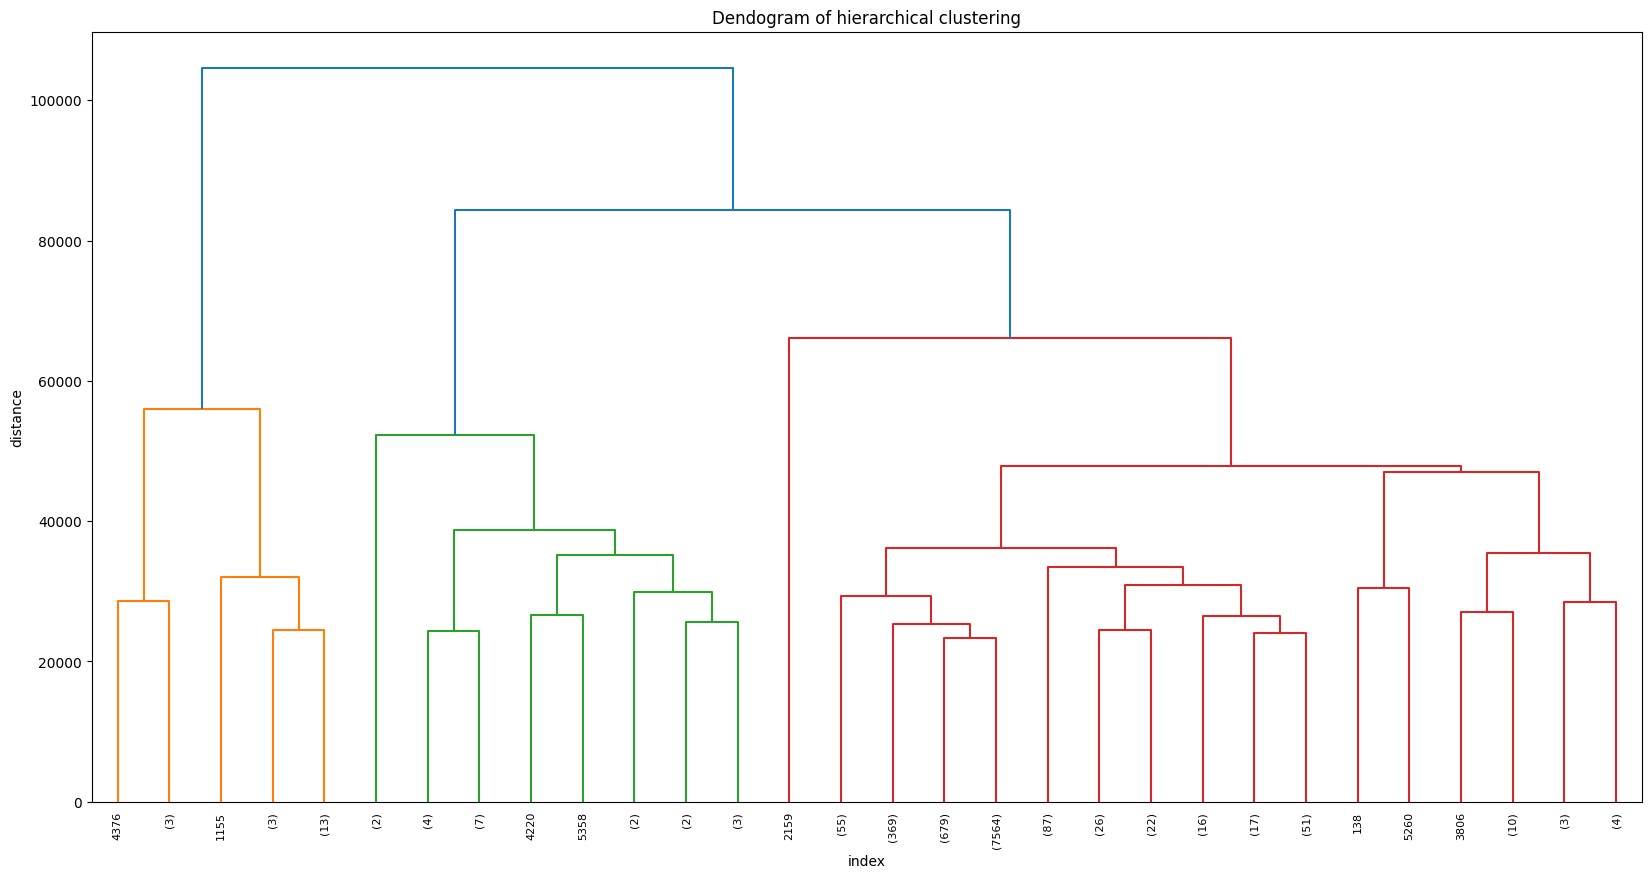

In [53]:
plt.figure(figsize=(20, 10))
plt.title("Dendogram of hierarchical clustering")
plt.xlabel("index")
plt.ylabel("distance")
 
dendrogram(
    Z,
    truncate_mode="lastp",
    leaf_rotation=90.,
    leaf_font_size=8.,  
)

plt.show()

Z dendrogramu je vidět, že nejlepší počet shluků jsou 3. 

In [54]:
k_clusters = fcluster(Z, 2, criterion="maxclust")

Pro ukázku si zase vykreslím v grafu dvě proměnné. Opět pro porovnání zvolím  PAYMENTS a MINIMUM_PAYMENTS. 

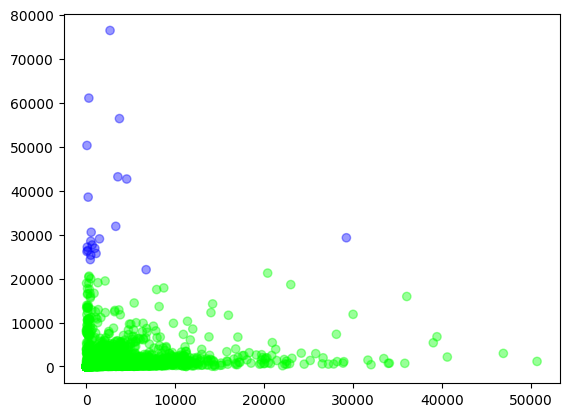

In [55]:
plt.scatter(X[:,13], X[:,14], c=k_clusters, cmap="brg", alpha=0.4)
plt.show()

In [57]:
score = silhouette_score(X,k_clusters)
print(score)

0.8133647147729802


Podle silhouette_score hierarchické shlukování metodou complete linkage dopadlo nejlépe.

## Standardizace, normalizace dat a zopakování shlukování

In [ ]:
normalizer = Normalizer(norm='l2').fit(df)
X_norm = normalizer.transform(df)

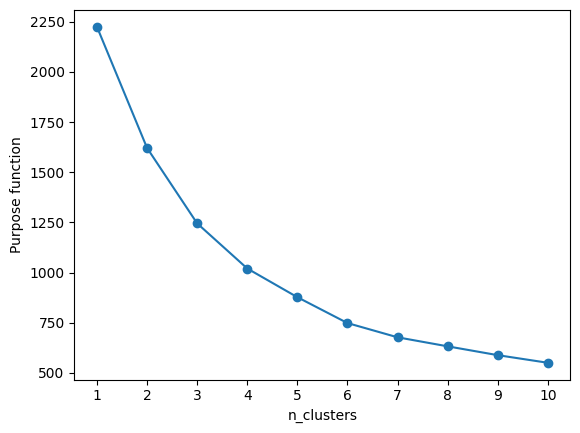

In [ ]:
array = np.arange(10)
array2 = np.arange(1,11)
for k in range(array.shape[0]):
    kmeans = KMeans(n_clusters=k+1, init = 'k-means++', random_state = 42)
    kmeans.fit(X_norm)
    array[k] = kmeans.inertia_

plt.xlabel('n_clusters')
plt.ylabel('Purpose function')
plt.xticks(array2)
plt.plot(array2, array, 'o-')
plt.show()

In [ ]:
k_means = KMeans(n_clusters = 2,   init = 'k-means++', random_state=42)
y_norm = k_means.fit_predict(X_norm)
score = silhouette_score(X_norm,y_norm)
print(score)

0.2997430429341671


Je vidět, že normalizace podle silhouette_score nepřinesla lepší výsledek (ani pro jiné normy). Zkusím ještě normalizovat data pro hierarchické shlukování. 

In [ ]:
Z = linkage(X_norm, method="complete", metric="euclidean")
k_clusters = fcluster(Z, 2, criterion="maxclust")
score = silhouette_score(X_norm,k_clusters)
print(score)

0.2723662701485757


Normalizace  ani zde nepomohla. Zkusím data naškálovat

In [17]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df)

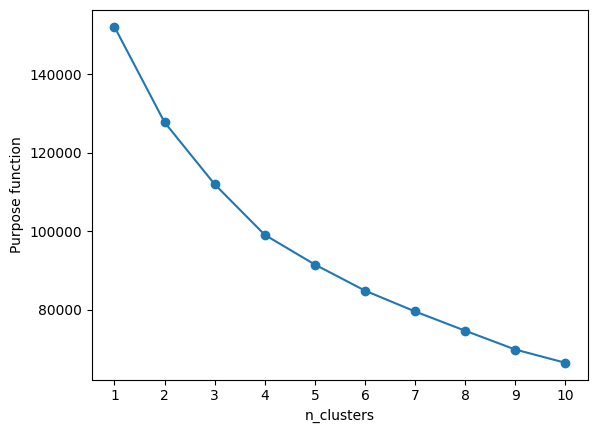

In [ ]:
array = np.arange(10)
array2 = np.arange(1,11)
for k in range(array.shape[0]):
    kmeans = KMeans(n_clusters=k+1, init = 'k-means++', random_state = 42)
    kmeans.fit(X_scaled)
    array[k] = kmeans.inertia_

plt.xlabel('n_clusters')
plt.ylabel('Purpose function')
plt.xticks(array2)
plt.plot(array2, array, 'o-')
plt.show()

In [ ]:
k_means = KMeans(n_clusters = 2,   init = 'k-means++', random_state=42)
y_scaled = k_means.fit_predict(X_scaled)
score = silhouette_score(X_scaled,y_scaled)
print(score)

0.20982491298187575


Ani standardizace se nepřinesla lepší výsledek u kMeans. Zkusím opět ještě hierarchické shlukování. 

In [18]:
Z = linkage(X_scaled, method="single", metric="euclidean")
k_clusters = fcluster(Z, 2, criterion="maxclust")
score = silhouette_score(X_scaled,k_clusters)
print(score)

0.840799663847683


Zde je zajímavé, že výsledek snad úplně nejlepší, ze všech pokusů avšak pokud si vykreslíme graf, rozhodně nedostame výsledek, který bychom si přáli. 

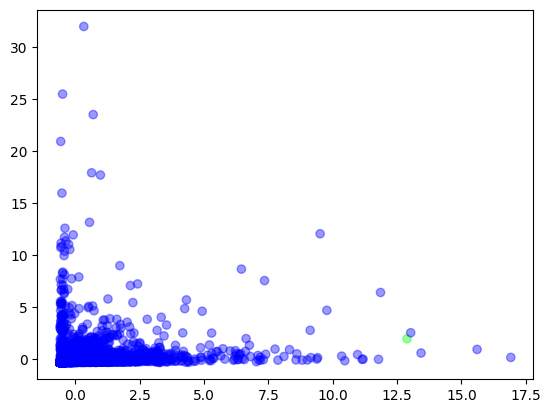

In [19]:
plt.scatter(X_scaled[:,13], X_scaled[:,14], c=k_clusters, cmap="brg", alpha=0.4)
plt.show()

## Závěr

Nakonec bych se  rozhodla data určitě nenormalizovat, či nestandardizovat. Výsledky byly buď špatné nebo zavádějící. Určitě bych nepoužila vlastní implementaci, protože je velmi pomalá. Jako nepřijatelnější mi přijde knihovní implementace kMeans a nebo hierarchické shlukování metodou complete linkage  nebo ward linkage s Euklidovskou metrikou. Metoda single linkage se zde také moc neosvědčila. Sloučí všechny body kromě jednoho do jednoho shluku a nechá jeden osamocený bod. Což není úplně to co požadujeme. 

Pokud se budeme zabývat pouze dvěma příznaky, které jsem sledovala v průběhu celého úkolu tedy PAYMENTS a MINIMUM_PAYMENTS, tak u implementace kMeans můžeme vidět, že shluky se vytvvořili především u uživatelů, kteří provedli málo plateb a naopak. Jen pár uživatelů, kteří mají vysokou nejnižší částku, ale i přes to, že měli málo plateb patří do skupiny lidí s vysokým počtem plateb. Tato korelace je podle mě nepřekvapivá. protože v jiných příznacích se mohou přibližovat k lidem, kteří platí často, tedy mají vysoké množství plateb v příznaku PAYMENTS.

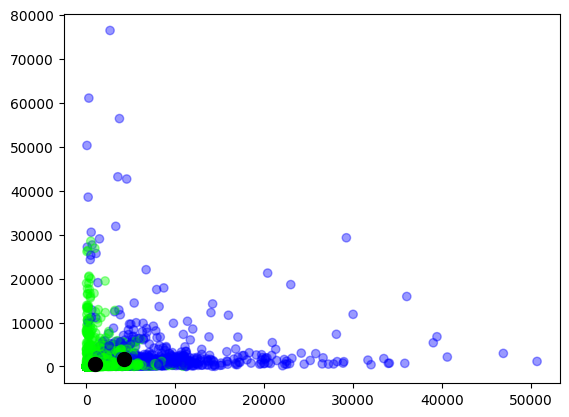

In [43]:
kmeans = KMeans(n_clusters = 2, random_state=42).fit(X)
plt.scatter(X[:,13], X[:,14], c=kmeans.labels_, cmap='brg', alpha=0.4) 
plt.scatter(kmeans.cluster_centers_[:,13], kmeans.cluster_centers_[:,14], c = 'black', s=100)
plt.show()

Naopak pokud se podíváme na predikci podle hierarchického shlukování, můžeme vidět, jako by body byly rozděleny konstantní funkcí. Od určitého bodu na ose zobrazující MINIMUM_PAYMENTS, jsou všechny body jiného shluku než pod ním. Tedy pokud je uživatelova minimální platba dostatečně vysoká patří do jednoho shluku a pokud ne patří do druhého. 

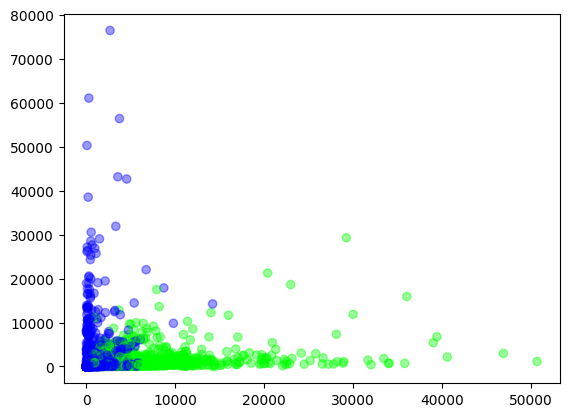

In [59]:
Z = linkage(X, method="complete", metric="euclidean")
k_clusters = fcluster(Z, 2, criterion="maxclust")
plt.scatter(X[:,13], X[:,14], c=k_clusters, cmap="brg", alpha=0.4)
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=5672211f-dc36-4d3a-876a-66b9ea329b1e' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>